# Linear Regression with Constraints during optimization

In this post, we will perform a constrained linear regression using Tensorflow. In linear regression, we create a model of the form Y=W.X+b. We will constrain W and b to be non-negative quantities. Such constraints are often useful in different applications. Say, if we want to model HPC total energy consumption as the air conditioner energy plus some additive noise, then the contribution of both these quantities should be non-negative in nature. See more on this [blog](https://nipunbatra.github.io/blog/2017/nn-linear-regression-tensorflow.html).

## There are some TODOs in this Notebook:
- TODO#1: (as always) read the codes and comments from begining to the end.
- TODO#2: change the constraints to W > 1 and b > 1.
- TODO#3: add Tensorboard to visualize the graph and see the gradients, costs during training.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

/home/sonvx/anaconda2/envs/ipykernel_py3_ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
# Showing graph on Jupyter Notebook
# source: https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
n_samples = 50
train_X = np.linspace(1, 50, n_samples)
train_Y = 10*train_X + 6 +40*np.random.randn(50)
train_Y = train_Y.reshape(n_samples, 1)
train_X = train_X.reshape(n_samples, 1)

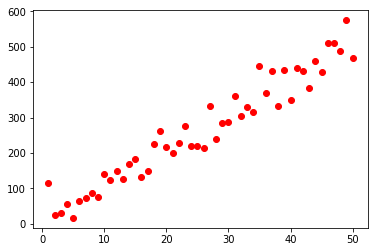

In [4]:
plt.plot(train_X, train_Y, 'ro')

In [5]:
# Location to write log files.
logs_path = '../../my_data/tf_lr_logs'

In [6]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('W', var)
        tf.summary.scalar('b', var)
        tf.summary.histogram('histogram', var)

In [7]:
# Model linear regression y = Wx + b. x is of shape `num_samples, 1`
x = tf.placeholder(tf.float32, [None, 1])

# Here we initialize W and b to be negative just to illustrate our point!
with tf.name_scope('W'):
    W = tf.Variable(-100*tf.ones([1, 1]))
    variable_summaries(W)
with tf.name_scope('b'):
    b = tf.Variable(-100*tf.ones([1]))
    variable_summaries(b)

product = tf.matmul(x,W)
y = product + b

In [8]:
# Clipping operation. 
clip_W = W.assign(tf.maximum(0., W))
clip_b = b.assign(tf.maximum(0., b))
clip = tf.group(clip_W, clip_b)

In [9]:
y_ = tf.placeholder(tf.float32, [None, 1])

# Cost function 
cost = tf.reduce_sum(tf.pow(y-y_, 2))/(2*n_samples)

with tf.name_scope('performance'):
    tf_cost_ph = tf.placeholder(tf.float32,shape=None,name='cost_summary')
    tf_cost_summary = tf.summary.scalar('cost_summary', tf_cost_ph)

In [10]:
lr = 0.001
steps = 10
# Training using Gradient Descent to minimize cost

train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)

init = tf.global_variables_initializer()

In [11]:
with tf.Session() as sess:
    sess.run(init)
    
    # writer.add_graph(sess.graph)
    writer = tf.summary.FileWriter(logs_path, sess.graph)
    
    for i in range(steps):
        print("*"*40)
        print("Iteration Number %d" %i)
        print("*"*40)
        print("\nBefore gradient computation")
        print("-"*40)
    
        print("W: %f" % sess.run(W))
        print("b: %f" % sess.run(b))
        feed = { x: train_X, y_: train_Y }
        sess.run(train_step, feed_dict=feed)
        print("\nAfter gradient computation")
        print("-"*40)
        print("W: %f" % sess.run(W))
        print("b: %f" % sess.run(b))
        print("\nAfter gradient projection")
        print("-"*40)
        # THIS line would ensure the projection step happens!
        sess.run(clip)
        print("W: %f" % sess.run(W))
        print("b: %f" % sess.run(b))
        with tf.name_scope('cost'):
            train_cost = sess.run(cost, feed_dict=feed)
            print("\nCost: %f" % train_cost)
        tf.summary.scalar('cost', train_cost)
        print("*"*40)
        # Tensorboard:
        summ = sess.run(tf_cost_summary, feed_dict={tf_cost_ph:train_cost})
        writer.add_summary(summ, i)
        
    learnt_W = sess.run(W)
    learnt_b = sess.run(b)

****************************************
Iteration Number 0
****************************************

Before gradient computation
----------------------------------------
W: -100.000000
b: -100.000000

After gradient computation
----------------------------------------
W: -2.752129
b: -97.084023

After gradient projection
----------------------------------------
W: 0.000000
b: 0.000000

Cost: 46330.589844
****************************************
****************************************
Iteration Number 1
****************************************

Before gradient computation
----------------------------------------
W: 0.000000
b: 0.000000

After gradient computation
----------------------------------------
W: 8.847876
b: 0.265977

After gradient projection
----------------------------------------
W: 8.847876
b: 0.265977

Cost: 1638.784302
****************************************
****************************************
Iteration Number 2
****************************************

Before g

Text(0.5, 1.0, 'Y = 10.30X + 0.33')

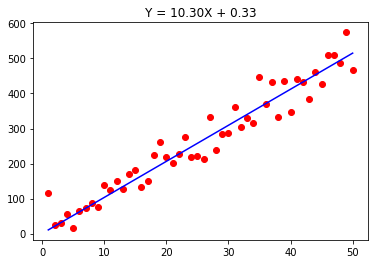

In [12]:
plt.plot(train_X, train_Y, 'ro')
pred_Y = np.multiply(train_X, learnt_W)+learnt_b
plt.plot(train_X, pred_Y, 'b')
plt.title("Y = {:0.2f}X + {:0.2f}".format(learnt_W[0, 0], learnt_b[0]))

# View on Tensorboard
- You will get this similar graph:

In [15]:
# View Tensorboard:
# Run
# !tensorboard --logdir=$logs_path --port 8890
# OR
show_graph(tf.get_default_graph().as_graph_def())

# Conclusions:
After this Notebook, you should know:
- How to build a linear regression using Tensorflow to fit a dataset.
- How to set constraints during optimization.
- How to add Tensorboard for visualization.